[Reference](https://towardsdatascience.com/fundamental-marketing-analytics-f875018391d5)

In [1]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=ea6b5cb3cf49da482db84053bdca5f502549fdbbc15f281f020958b3484fab5b
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lorenzoyeung/Fundamental-marketing-analytics-/master/data.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,12/30/19 00:01,0,1,1
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,12/29/19 07:03,7,3,1
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,12/12/19 18:21,18,21,1
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,12/22/19 15:13,15,13,1
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,12/18/19 12:38,12,38,1


In [4]:
df["order_date"] = df["order_date"].astype('datetime64[ns]')
print(df["order_date"].max(),"\n",df["order_date"].min())

2020-01-01 05:13:00 
 2019-01-01 03:07:00


In [5]:
df['days_since'] = (pd.Timestamp('2020-01-01') - df['order_date']).dt.days

In [6]:
rfm = sqldf("SELECT customer_id, MIN(days_since) AS 'recency', COUNT(*) AS 'frequency', AVG(sales) AS 'amount' FROM df GROUP BY 1", globals())
rfm.describe()

,customer_id,recency,frequency,amount
count,178437.000000,178437.000000,178437.000000,178437.000000
mean,230452.000000,165.637956,1.042104,182.687511
std,51510.469329,107.145857,0.211617,328.497937
min,141234.000000,-1.000000,1.000000,2.990000
25%,185843.000000,66.000000,1.000000,11.950000
50%,230452.000000,166.000000,1.000000,14.950000
75%,275061.000000,259.000000,1.000000,150.000000
max,319670.000000,364.000000,5.000000,3400.000000


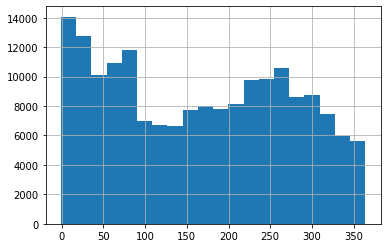

In [7]:
rfm.recency.hist(bins=20)

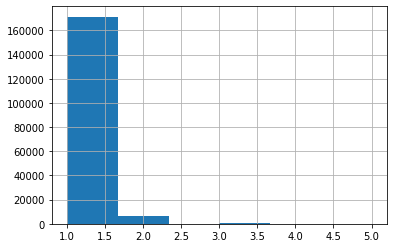

In [8]:
rfm.frequency.hist(bins=6)

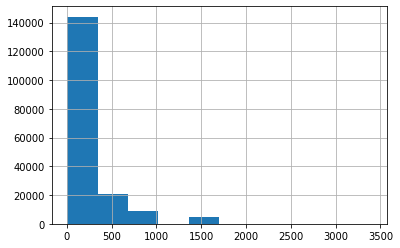

In [9]:
rfm.amount.hist()

In [10]:
new_data = rfm
new_data.head()
new_data = new_data.set_index(new_data.customer_id).iloc[:,1:4]
new_data.head()

,recency,frequency,amount
customer_id,,,
141234,343,1,700.00
141235,337,1,14.95
141236,348,1,23.98
141237,360,1,149.99
141238,340,1,11.99


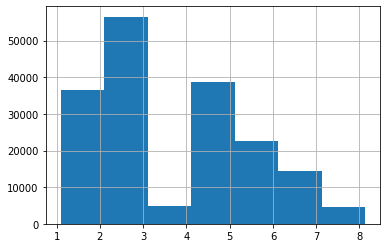

In [11]:
new_data.amount = np.log(new_data.amount)
new_data.amount.hist(bins=7)

In [12]:
new_data = pd.DataFrame(scale(new_data), index=new_data.index, columns=new_data.columns)
new_data.head()

,recency,frequency,amount
customer_id,,,
141234,1.655337,-0.198966,1.528147
141235,1.599339,-0.198966,-0.536610
141236,1.702003,-0.198966,-0.282964
141237,1.814000,-0.198966,0.701190
141238,1.627338,-0.198966,-0.655050


# Running a Hierarchical Segmentation


In [13]:
new_data_sample = new_data.iloc[::10, :]

In [14]:
c = linkage(new_data_sample, method='ward')

In [15]:
members = pd.DataFrame(cut_tree(c, n_clusters = 3), index=new_data_sample.index, columns=['ClusterNumber'])
members.ClusterNumber.value_counts(sort=False)

0    7544
1    9568
2     732
Name: ClusterNumber, dtype: int64

In [16]:
members.iloc[0:10]

,ClusterNumber
customer_id,
141234,0
141244,0
141254,1
141264,0
141274,1
141284,1
141294,0
141304,1
141314,0
